# Preliminaries

Importing python packages and setting display parameters

In [1]:
import math as mt
import random as rnd
import numpy as np

from deap import base, creator, tools

import numba
from numba import jit
import joblib

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import statistics as stats

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = "retina"

plt.style.use("default")
plt.style.use("bmh")
# plt.rcParams.update({"figure.autolayout": True})
plt.rcParams["figure.figsize"] = (12, 9)
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 100

In [3]:
pd.set_option("display.latex.repr", True)

In [ ]:
pd.set_option("display.latex.longtable", True)

# Fitness Landscape Definition

In [4]:
# Problem domain
x_min = -15
x_max = 15
y_min = -15
y_max = 15

# Known minimum
x_point = -6.01717
y_point = 9.06022

domain = (x_min, x_max, y_min, y_max)
point = (x_point, y_point)
img_size = (8.5, 4.25)

# Problem definition


@jit
def g_fun(x, y):
    mag = np.sqrt(x ** 2.0 + y ** 2.0)
    val = -(50.0 * np.sinc(mag / np.pi) - mag)
    return val.item()


@jit
def f_fun(x, y):
    x_min = -6.01717
    y_min = 9.06022
    f_min = (
        g_fun(x_min + 11.0, y_min + 9.0)
        + g_fun(x_min - 11.0, y_min - 3.0)
        + g_fun(x_min + 6.0, y_min - 9.0)
    )
    tripsinc = (
        g_fun(x + 11.0, y + 9.0)
        + g_fun(x - 11.0, y - 3.0)
        + g_fun(x + 6.0, y - 9.0)
        - (f_min)
    )
    return tripsinc

In [5]:
@jit
def evaluate(individual):
    x = individual[0]
    y = individual[1]
    fitness = f_fun(x, y)
    return (fitness,)

In [6]:
# Testing the minimum
print(f_fun(-6.01717, 9.06022))

0.0


In [7]:
# Testing the function
print(f_fun(-1.0, -1.0), f_fun(-11.0, -9.0), f_fun(11.0, 3.0), f_fun(-6.0, 9.0))

50.62059878583003 5.177364279021976 6.107247239602234 0.031278340140559635


In [23]:
x_min = -6.01717
y_min = 9.06022
f_min = (
        g_fun(x_min + 11.0, y_min + 9.0)
        + g_fun(x_min - 11.0, y_min - 3.0)
        + g_fun(x_min + 6.0, y_min - 9.0)
    )
f_min

-10.843177780950036

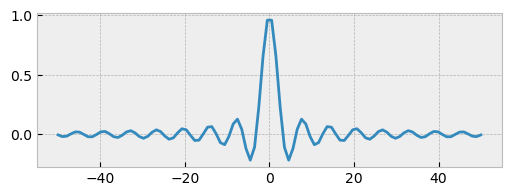

In [15]:
plot_x = np.linspace(-50,50,100)
plot_y = np.sinc(plot_x/np.pi)

fig,ax = plt.subplots(figsize=(6,2))
plt.plot(plot_x,plot_y)

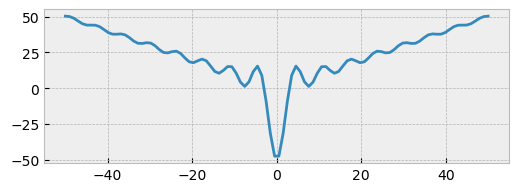

In [14]:
def g_fun_mono(z):
    mag = np.sqrt(z ** 2.0)
    val = -(50.0 * np.sinc(mag / np.pi) - mag)
    return val

plot_x = np.linspace(-50,50,100)
plot_y = g_fun_mono(plot_x)

fix,ax = plt.subplots(figsize=(6,2))
plt.plot(plot_x,plot_y)

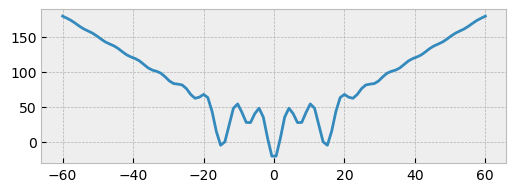

In [22]:
plot_x = np.linspace(-60,60,100)
plot_y = g_fun_mono(plot_x) + g_fun_mono(plot_x-15) + g_fun_mono(plot_x+15)

fix,ax = plt.subplots(figsize=(6,2))
plt.plot(plot_x,plot_y)

# Running the Evolutionary Algorithm

## Setting the EA's parameters

In [7]:
# Algorithm parameters
# Number of replicates, and generations per experiment
rep_end = 1
births_end = 120e3

# Genes
gen_size = 2
# Population size
pop_size = 20
# Progeny and parents size
b_ratio = 3
par_size = b_ratio * pop_size

# Progeny parameters
## Crossover probability per gene
cx_pb = 0.5
## Mutation probability per gene
mut_pb = 0.5
## Mutation strength
sigma = 2.5

# Selection by tournament
# Tournament size parent selection
k_p = 2
# Tournament size survivor selection
k_s = 6

## Defining the EA elements

We define that the fitness is related to a minimizing problem, and that each individual is represented with a list of numbers

In [8]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

We start the DEAP toolset. At creation, each individual will have 2 genes of type "float" that are randomly initialized in the range [-15; 15].

In [9]:
toolbox = base.Toolbox()

In [10]:
toolbox.register("attr_float", rnd.uniform, -15, 15)
toolbox.register(
    "individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=gen_size
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

We add our landscape to the toolset, indicate that the mating will use a uniform crossover on a per-gene basis, that the mutation will be also on a per-gene basis with a value taken from a gaussian distribution, and that parent and survivor selections will use tournament selection.

In [11]:
toolbox.register("evaluate", evaluate)

toolbox.register("mate", tools.cxUniform, indpb=cx_pb)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=sigma, indpb=mut_pb)

toolbox.register("par_select", tools.selTournament, tournsize=k_p)
toolbox.register("sur_select", tools.selTournament, tournsize=k_s)

We define that for each generation we'll summarize the fitnesses with median, mean, standard deviation, and store the best and worst fitnesses in the generation.

In [12]:
stat = tools.Statistics(key=lambda ind: ind.fitness.values[0])

stat.register("med", stats.median)
stat.register("avg", stats.mean)
stat.register("std", stats.stdev)
stat.register("best", min)
stat.register("worst", max)

We invoque the data recording logbook.

In [13]:
logbook = tools.Logbook()

## Single Run of the EA Experiments
1 Experiment
L-> 1 Parameter set for the experiment.
>L-> 1 Replicate.
>>L-> The replicate is affected due to the randomness seed.

In [14]:
# starting seed
rnd.seed(42)

In [15]:
%%timeit
if __name__ == "__main__":
    for rep_n in range(rep_end):
        rep_seed = rnd.randint(0, 999)
        rnd.seed(rep_seed)
        # We initialize the population and evaluate the individuals' fitnesses
        pop = toolbox.population(n=pop_size)
        fitnesses = toolbox.map(toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        # We start the logbook
        record = stat.compile(pop)
        births = len(pop)
        logbook.record(rep=rep_n + 1, seed=rep_seed, births=births, **record)

        while births < births_end:
            # Select Parents and clone them as base for offsprings
            parents = toolbox.par_select(pop, par_size)
            offspring = [toolbox.clone(ind) for ind in parents]
            births = births + len(offspring)

            # Aplly crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                toolbox.mate(child1, child2)

            # Apply mutation
            for mutant in offspring:
                toolbox.mutate(mutant)
                del mutant.fitness.values

            fitnesses = toolbox.map(toolbox.evaluate, offspring)
            for ind, fit in zip(offspring, fitnesses):
                ind.fitness.values = fit

            pop = toolbox.sur_select((pop + offspring), pop_size)

            record = stat.compile(pop)
            logbook.record(rep=rep_n + 1, seed=rep_seed, births=births, **record)

C:\Anaconda3\envs\ea_thesis\lib\site-packages\numba\ir_utils.py:1958: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'individual' of function 'evaluate'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-8d5bf46f22a6>", line 2:
@jit
def evaluate(individual):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


8.5 s ± 578 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Data Analysis

We transform the records into a Data Frame

In [16]:
pop_records = [record for record in logbook]
fitness_res = pd.DataFrame.from_dict(pop_records)

#### Fitness development

Wall time: 47.3 s


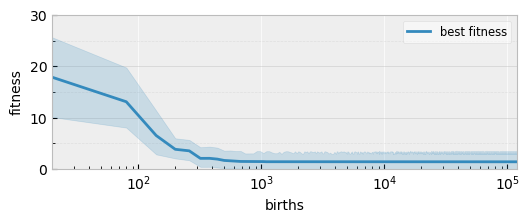

In [25]:
%%time
fig, ax = plt.subplots(figsize=(6, 2))
ax = sns.lineplot(x="births", y="best", data=fitness_res, label="best fitness")

ax.set_axisbelow(True)
ax.minorticks_on()

ax.set(xscale="log")

ax.set_xlabel("births", fontsize="medium")
ax.set_ylabel("fitness", fontsize="medium")

ax.set_xlim((2e1, 120e3))
ax.set_ylim((0, 30))

ax.grid(True, axis="x", which="major", alpha=1, color="w", ls="-")
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.grid(True, axis="y", which="major", alpha=0.5, ls="-")
ax.grid(True, axis="y", which="minor", alpha=0.25, ls="--")

ax.legend(fontsize="small", facecolor="white", framealpha=0.5)

ax.plot()

## 100 Executions of the EA
1 Experiment
>L-> 1 Parameter set for the experiment.
>>L-> 100 Replicate.
>>>L-> Each replicate is different due to randomness effects.

### Changing parameters

In [26]:
# Restarting seed
rnd.seed(42)

# Algorithm parameters
# Number of replicates
rep_end = 50

### Execution

In [27]:
%%time
logbook.clear()

if __name__ == "__main__":
    for rep_n in range(rep_end):
        rep_seed = rnd.randint(0, 999)
        rnd.seed(rep_seed)
        # We initialize the population and evaluate the individuals' fitnesses
        pop = toolbox.population(n=pop_size)
        fitnesses = toolbox.map(toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        # We start the logbook
        record = stat.compile(pop)
        births = len(pop)
        logbook.record(rep=rep_n + 1, seed=rep_seed, births=births, **record)

        while births < births_end:
            # Select Parents and clone them as base for offsprings
            parents = toolbox.par_select(pop, par_size)
            offspring = [toolbox.clone(ind) for ind in parents]
            births = births + len(offspring)

            # Aplly crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                toolbox.mate(child1, child2)

            # Apply mutation
            for mutant in offspring:
                toolbox.mutate(mutant)
                del mutant.fitness.values

            fitnesses = toolbox.map(toolbox.evaluate, offspring)
            for ind, fit in zip(offspring, fitnesses):
                ind.fitness.values = fit

            pop = toolbox.sur_select((pop + offspring), pop_size)

            record = stat.compile(pop)
            logbook.record(rep=rep_n + 1, seed=rep_seed, births=births + 1, **record)

Wall time: 7min 2s


In [30]:
pickle_file = "./pickle/C_01.joblib"

In [ ]:
%%time
with open(pickle_file, "wb") as handle:
    joblib.dump(logbook, handle, compress=("xz", 2))

In [44]:
%%time
with open(pickle_file, "rb") as handle:
    logb = joblib.load(handle)

Wall time: 4.51 s


### Data Analysis

We transform the records into a Data Frame

In [91]:
fitness_res = pd.DataFrame.from_dict(logb)
fitness_res = fitness_res[
    ["rep", "seed", "births", "avg", "std", "med", "worst", "best"]
]

We filter the values of the last generation

In [100]:
query = fitness_res["births"] >= births_end
fin_fit_120k = fitness_res[query]
query = fitness_res["births"] == 60021
fin_fit_60k = fitness_res[query]
query = fitness_res["births"] == 30021
fin_fit_30k = fitness_res[query]

50

Top 10 best (lowest-fitness) individuals

In [49]:
fin_fit_120k.sort_values(by=["best"]).head(10)

,rep,seed,births,avg,std,med,worst,best
32015,16,998,120021,1.652427e-08,0.000000,1.652427e-08,1.652427e-08,1.652427e-08
4001,2,830,120021,2.130178e-03,0.008500,4.439901e-08,3.797312e-02,4.439901e-08
76037,38,830,120021,2.130178e-03,0.008500,4.439901e-08,3.797312e-02,4.439901e-08
66032,33,438,120021,6.898715e-02,0.308520,5.044252e-08,1.379742e+00,5.044252e-08
88043,44,372,120021,6.717306e-01,1.621309,6.371828e-08,5.780939e+00,6.371828e-08
16007,8,372,120021,6.717306e-01,1.621309,6.371828e-08,5.780939e+00,6.371828e-08
68033,34,377,120021,3.596382e-01,1.608350,1.066240e-07,7.192762e+00,1.066240e-07
70034,35,492,120021,1.401409e-07,0.000000,1.401409e-07,1.401409e-07,1.401409e-07
48023,24,567,120021,9.881502e-01,3.500465,2.850990e-07,1.522306e+01,2.850990e-07
38018,19,834,120021,1.543343e-01,0.579279,3.121537e-07,2.565175e+00,3.121537e-07


Top 10 worst (highest-fitness) individuals

In [50]:
fin_fit_120k.sort_values(by=["best"], ascending=False).head(10)

,rep,seed,births,avg,std,med,worst,best
74036,37,35,120021,6.094170,0.041399,6.084913,6.270054,6.084913
62030,31,68,120021,6.222341,0.610549,6.084911,8.816222,6.084911
94046,47,944,120021,6.385377,1.286749,6.084910,11.847139,6.084910
22010,11,944,120021,6.385377,1.286749,6.084910,11.847139,6.084910
46022,23,23,120021,6.084909,0.000000,6.084909,6.084909,6.084909
20009,10,689,120021,6.084909,0.000000,6.084909,6.084909,6.084909
92045,46,689,120021,6.084909,0.000000,6.084909,6.084909,6.084909
84041,42,164,120021,6.084909,0.000000,6.084909,6.084909,6.084909
12005,6,164,120021,6.084909,0.000000,6.084909,6.084909,6.084909
60029,30,815,120021,6.126880,0.129184,6.084909,6.504619,6.084909


### Visualization

#### Aggregated results

In [101]:
fin_fit_best_120k = fin_fit_120k["best"]
fin_fit_best_60k = fin_fit_60k["best"]
fin_fit_best_30k = fin_fit_30k["best"]

Wall time: 158 ms


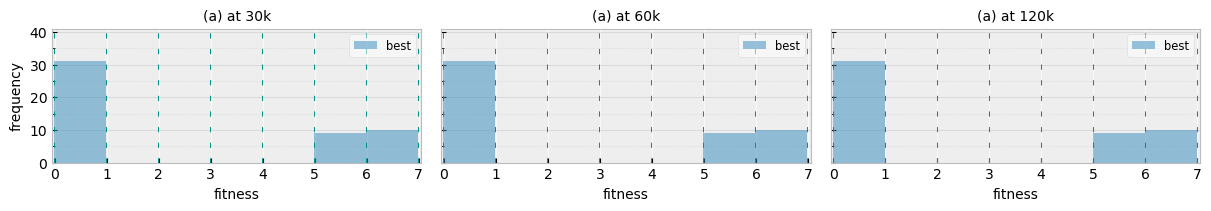

In [106]:
%%time
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    sharey="row",
    sharex="row",
    constrained_layout=True,
    figsize=(12, 2),
)

bins = np.linspace(-0.01, 6.99, 7 + 1)
axs[0].hist(fin_fit_best_30k, bins, label="best", alpha=0.5)
axs[1].hist(fin_fit_best_60k, bins, label="best", alpha=0.5)
axs[2].hist(fin_fit_best_120k, bins, label="best", alpha=0.5)

axs[0].set_title("(a) at 30k", fontsize="medium")
axs[1].set_title("(a) at 60k", fontsize="medium")
axs[2].set_title("(a) at 120k", fontsize="medium")

axs[0].set_ylabel("frequency", fontsize="medium")

for ax in axs.flatten():
    ax.vlines(bins, 0, 40, colors="xkcd:teal", linestyles=(0, (5, 10)), linewidths=0.75)

    ax.set_ylim((0, 40 + 1))
    ax.set_xlim((-0.05, 7.05))

    ax.set_xlabel("fitness", fontsize="medium")

    ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.grid(True, axis="y", which="major", alpha=0.5, ls="-")
    ax.grid(True, axis="y", which="minor", alpha=0.25, ls="--")
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    ax.grid(True, axis="x", which="major", alpha=1, color="w", ls="-")

    ax.legend(fontsize="small", facecolor="white", framealpha=0.5)

Wall time: 123 ms


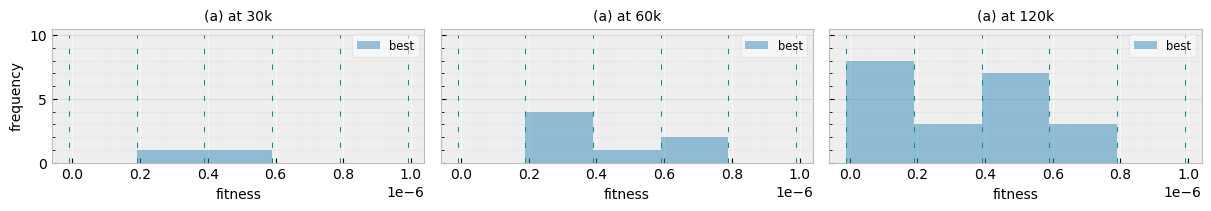

In [108]:
%%time
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    sharey="row",
    sharex="row",
    constrained_layout=True,
    figsize=(12, 2),
)
bins = np.linspace(-1e-8, 1e-6 - 1e-8, num=6)
axs[0].hist(fin_fit_best_30k, bins, label="best", alpha=0.5)
axs[1].hist(fin_fit_best_60k, bins, label="best", alpha=0.5)
axs[2].hist(fin_fit_best_120k, bins, label="best", alpha=0.5)

axs[0].set_title("(a) at 30k", fontsize="medium")
axs[1].set_title("(a) at 60k", fontsize="medium")
axs[2].set_title("(a) at 120k", fontsize="medium")

axs[0].set_ylabel("frequency", fontsize="medium")

for ax in axs.flatten():
    ax.vlines(bins, 0, 10, colors="xkcd:teal", linestyles=(0, (5, 10)), linewidths=0.75)

    ax.set_ylim((0, None))

    ax.set_xlabel("fitness", fontsize="medium")

    ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(True, axis="y", which="major", alpha=0.5, ls="-")
    ax.grid(True, axis="y", which="minor", alpha=0.25, ls="--")
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    ax.grid(True, axis="x", which="major", alpha=1, color="w", ls="-")
    ax.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))

    ax.legend(fontsize="small", facecolor="white", framealpha=0.5)

Wall time: 49.6 s


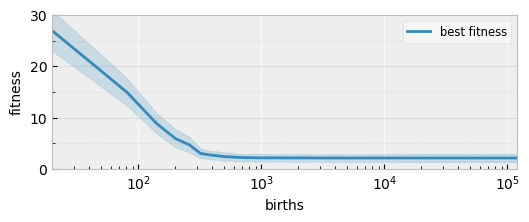

In [72]:
%%time
fig, ax = plt.subplots(figsize=(6, 2))
ax = sns.lineplot(x="births", y="best", data=fitness_res, label="best fitness")

ax.set_axisbelow(True)
ax.minorticks_on()

ax.set(xscale="log")

ax.set_xlabel("births", fontsize="medium")
ax.set_ylabel("fitness", fontsize="medium")

ax.set_xlim((2e1, 120e3))
ax.set_ylim((0, 30))

ax.grid(True, axis="x", which="major", alpha=1, color="w", ls="-")
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.grid(True, axis="y", which="major", alpha=0.5, ls="-")
ax.grid(True, axis="y", which="minor", alpha=0.25, ls="--")

ax.legend(fontsize="small", facecolor="white", framealpha=0.5)
ax.plot()

Wall time: 578 ms


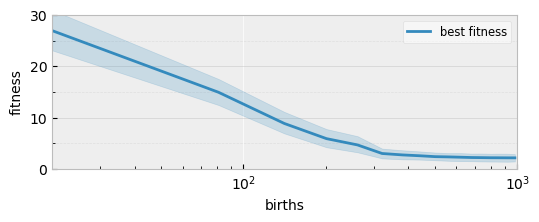

In [75]:
%%time
query = fitness_res["births"] <= 1e3
fig, ax = plt.subplots(figsize=(6, 2))
ax = sns.lineplot(x="births", y="best", data=fitness_res[query], label="best fitness")

ax.set_axisbelow(True)
ax.minorticks_on()

ax.set(xscale="log")

ax.set_xlabel("births", fontsize="medium")
ax.set_ylabel("fitness", fontsize="medium")

ax.set_xlim((2e1, 1e3))
ax.set_ylim((0, 30))

ax.grid(True, axis="x", which="major", alpha=1, color="w", ls="-")
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.grid(True, axis="y", which="major", alpha=0.5, ls="-")
ax.grid(True, axis="y", which="minor", alpha=0.25, ls="--")

ax.legend(fontsize="small", facecolor="white", framealpha=0.5)

ax.plot()

Wall time: 50.7 s


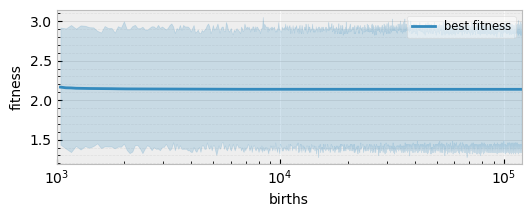

In [89]:
%%time
query = fitness_res["births"] >= 1e3
fig, ax = plt.subplots(figsize=(6, 2))
ax = sns.lineplot(x="births", y="best", data=fitness_res[query], label="best fitness")

ax.set_axisbelow(True)
ax.minorticks_on()

ax.set(xscale="log")

ax.set_xlabel("births", fontsize="medium")
ax.set_ylabel("fitness", fontsize="medium")

ax.set_xlim((1e3, 120e3))
# ax.set_ylim((2.13, 2.18))

ax.grid(True, axis="x", which="major", alpha=1, color="w", ls="-")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.grid(True, axis="y", which="major", alpha=0.5, ls="-")
ax.grid(True, axis="y", which="minor", alpha=0.25, ls="--")

ax.legend(fontsize="small", facecolor="white", framealpha=0.5)

ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

ax.plot()

Wall time: 50.6 s


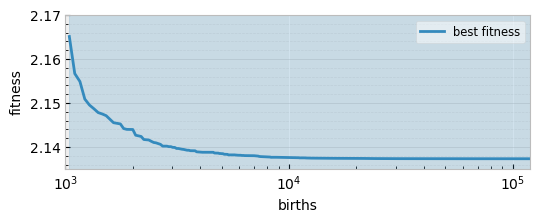

In [90]:
%%time
query = fitness_res["births"] >= 1e3
fig, ax = plt.subplots(figsize=(6, 2))
ax = sns.lineplot(x="births", y="best", data=fitness_res[query], label="best fitness")

ax.set_axisbelow(True)
ax.minorticks_on()

ax.set(xscale="log")

ax.set_xlabel("births", fontsize="medium")
ax.set_ylabel("fitness", fontsize="medium")

ax.set_xlim((1e3, 120e3))
ax.set_ylim((2.135, 2.17))

ax.grid(True, axis="x", which="major", alpha=1, color="w", ls="-")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.grid(True, axis="y", which="major", alpha=0.5, ls="-")
ax.grid(True, axis="y", which="minor", alpha=0.25, ls="--")

ax.legend(fontsize="small", facecolor="white", framealpha=0.5)

ax.plot()